In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os

import numpy as np
import torch
from torch import distributions
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from bbb.utils.pytorch_setup import DEVICE
from bbb.config.parameters import PriorParameters

In [4]:
# plt.rcParams.update({'axes.titlesize': 'large', 'axes.labelsize': 'medium'})
plt.rc('font', size=16)
colors_hex = {'blue': '#1F77B4', 'orange': '#FF7F0E', 'green': '#2CA02C'}
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

## Single Gaussian

In [5]:
prior_params_g = PriorParameters(
    w_sigma=1.,
    b_sigma=1.,
    w_sigma_2=0.2,
    b_sigma_2=0.2,
    w_mixture_weight=0.5,
    b_mixture_weight=0.5,
)

In [6]:
w_prior_g = distributions.Normal(0, prior_params_g.w_sigma)
b_prior_g = distributions.Normal(0, prior_params_g.b_sigma)

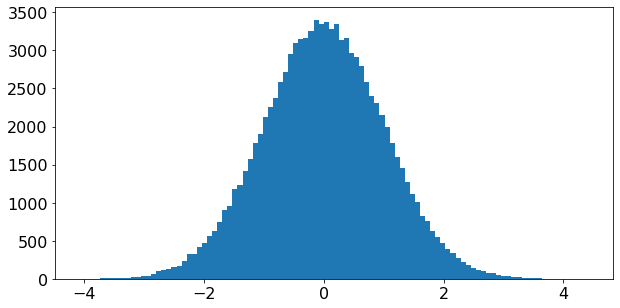

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
w_prior_mog_samples = w_prior_g.sample(sample_shape=(100000,))
ax.hist(w_prior_mog_samples.cpu().numpy(), bins=100)
pass

<AxesSubplot:ylabel='Density'>

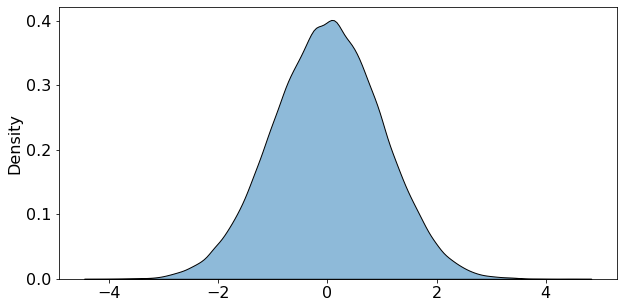

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
w_prior_mog_samples = w_prior_g.sample(sample_shape=(100000,))
sns.kdeplot(w_prior_mog_samples, fill=True, ax=ax, color=colors[0], alpha=0.5, multiple="stack")

In [9]:
torch.diff(w_prior_g.cdf(torch.tensor([-0.3, 0.3], device=DEVICE)))

tensor([0.2358])

In [10]:
torch.diff(w_prior_g.cdf(torch.tensor([-0.4, 0.4], device=DEVICE)))

tensor([0.3108])

In [11]:
torch.diff(w_prior_g.cdf(torch.tensor([-0.5, 0.5], device=DEVICE)))

tensor([0.3829])

## MoG

In [12]:
prior_params_mog = PriorParameters(
    w_sigma=np.exp(-1),
    b_sigma=np.exp(-1),
    w_sigma_2=np.exp(-7),
    b_sigma_2=np.exp(-7),
    w_mixture_weight=0.5,
    b_mixture_weight=0.5,
)

In [13]:
w_mix = distributions.Categorical(torch.tensor((prior_params_mog.w_mixture_weight, 1-prior_params_mog.w_mixture_weight), device=DEVICE))
b_mix = distributions.Categorical(torch.tensor((prior_params_mog.b_mixture_weight, 1-prior_params_mog.b_mixture_weight), device=DEVICE))

# Specify the individual components - whilst these appear to be multivariate Gaussians they will be seperated
w_norm_comps = distributions.Normal(torch.zeros(2, device=DEVICE), torch.tensor((prior_params_mog.w_sigma, prior_params_mog.w_sigma_2), device=DEVICE, dtype=torch.float32))
b_norm_comps = distributions.Normal(torch.zeros(2, device=DEVICE), torch.tensor((prior_params_mog.b_sigma, prior_params_mog.b_sigma_2), device=DEVICE, dtype=torch.float32))

# Easier version to play around with
# w_norm_comps = distributions.Normal(torch.tensor([-1.,1.], device=DEVICE), torch.tensor((prior_params_mog.w_sigma, prior_params_mog.w_sigma_2), device=DEVICE, dtype=torch.float32))
# b_norm_comps = distributions.Normal(torch.tensor([0.,0.], device=DEVICE), torch.tensor((prior_params_mog.b_sigma, prior_params_mog.b_sigma_2), device=DEVICE, dtype=torch.float32))

# Create the GMMs
w_prior_mog = distributions.MixtureSameFamily(w_mix, w_norm_comps)
b_prior_mog = distributions.MixtureSameFamily(b_mix, b_norm_comps)

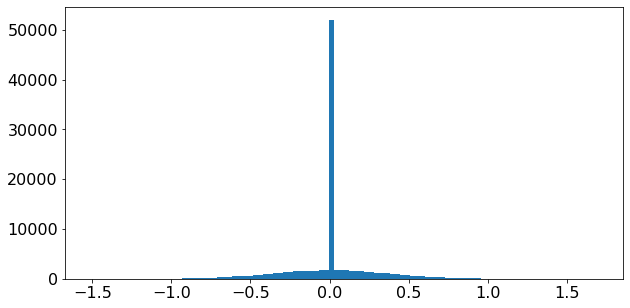

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
w_prior_mog_samples =w_prior_mog.sample(sample_shape=(100000,))
ax.hist(w_prior_mog_samples.cpu().numpy(), bins=100)
pass

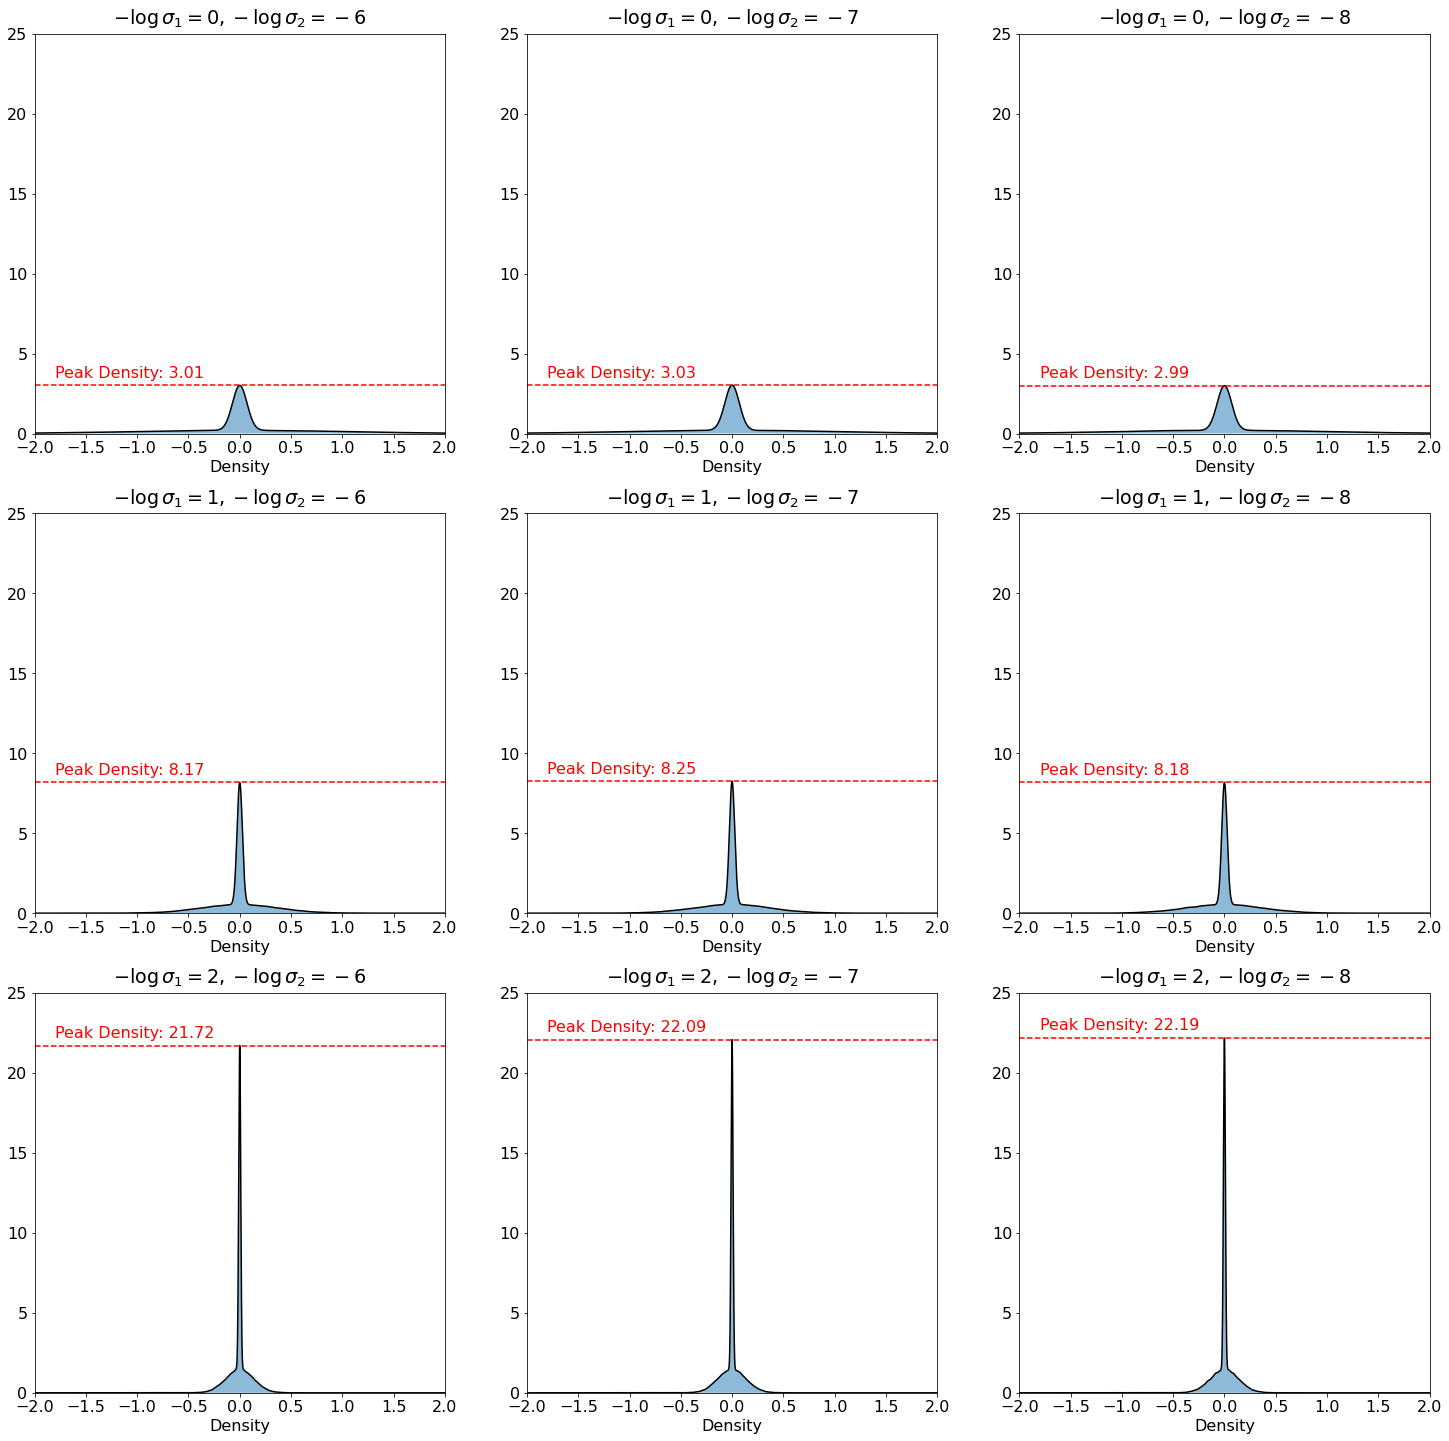

In [20]:
fig, ax = plt.subplots(3, 3, figsize=(25, 25))
for idx, sigma_1 in enumerate([0,1,2]):
    for idy, sigma_2 in enumerate([6,7,8]):
        prior_params_mog = PriorParameters(
            w_sigma=np.exp(-sigma_1),
            b_sigma=np.exp(-sigma_1),
            w_sigma_2=np.exp(-sigma_2),
            b_sigma_2=np.exp(-sigma_2),
            w_mixture_weight=0.5,
            b_mixture_weight=0.5,
        )

        w_mix = distributions.Categorical(torch.tensor((prior_params_mog.w_mixture_weight, 1-prior_params_mog.w_mixture_weight), device=DEVICE))
        b_mix = distributions.Categorical(torch.tensor((prior_params_mog.b_mixture_weight, 1-prior_params_mog.b_mixture_weight), device=DEVICE))

        # Specify the individual components - whilst these appear to be multivariate Gaussians they will be seperated
        w_norm_comps = distributions.Normal(torch.zeros(2, device=DEVICE), torch.tensor((prior_params_mog.w_sigma, prior_params_mog.w_sigma_2), device=DEVICE, dtype=torch.float32))
        b_norm_comps = distributions.Normal(torch.zeros(2, device=DEVICE), torch.tensor((prior_params_mog.b_sigma, prior_params_mog.b_sigma_2), device=DEVICE, dtype=torch.float32))

        # Easier version to play around with
        # w_norm_comps = distributions.Normal(torch.tensor([-1.,1.], device=DEVICE), torch.tensor((prior_params_mog.w_sigma, prior_params_mog.w_sigma_2), device=DEVICE, dtype=torch.float32))
        # b_norm_comps = distributions.Normal(torch.tensor([0.,0.], device=DEVICE), torch.tensor((prior_params_mog.b_sigma, prior_params_mog.b_sigma_2), device=DEVICE, dtype=torch.float32))

        # Create the GMMs
        w_prior_mog = distributions.MixtureSameFamily(w_mix, w_norm_comps)
        b_prior_mog = distributions.MixtureSameFamily(b_mix, b_norm_comps)

        w_prior_mog_samples = w_prior_mog.sample(sample_shape=(100000,))
        kde_linspace = np.linspace(-2,2,10000)
        kde_vals = stats.gaussian_kde(w_prior_mog_samples)(kde_linspace)
        ax[idx, idy].plot(kde_linspace, kde_vals, c='k')
        ax[idx, idy].fill_between(kde_linspace, 0, kde_vals, alpha=0.5)

        kde_max = kde_vals.max()
        ax[idx, idy].axhline(kde_max, ls='--', c='r')
        ax[idx, idy].text(kde_linspace.min()+0.2, kde_max+0.5, f'Peak Density: {kde_max:.2f}', c='r')

        ax[idx, idy].set_xlabel('Weight')
        ax[idx, idy].set_xlabel('Density')

        ax[idx, idy].set_xlim(-2,2)
        ax[idx, idy].set_ylim(0,25)
        ax[idx, idy].set_title(rf'$-\log \sigma_1={sigma_1}, -\log \sigma_2=-{sigma_2}$', pad=10)

plt.savefig(os.path.join("../plots/theory/mog_dists.png"), pad_inches=0.2, bbox_inches='tight')

2022-03-31 02:01:52,336 - matplotlib.legend - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2022-03-31 02:01:52,636 - matplotlib.legend - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2022-03-31 02:01:52,917 - matplotlib.legend - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2022-03-31 02:01:53,197 - matplotlib.legend - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2022-03-31 02:01:53,486 - matplotlib.legend - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an 

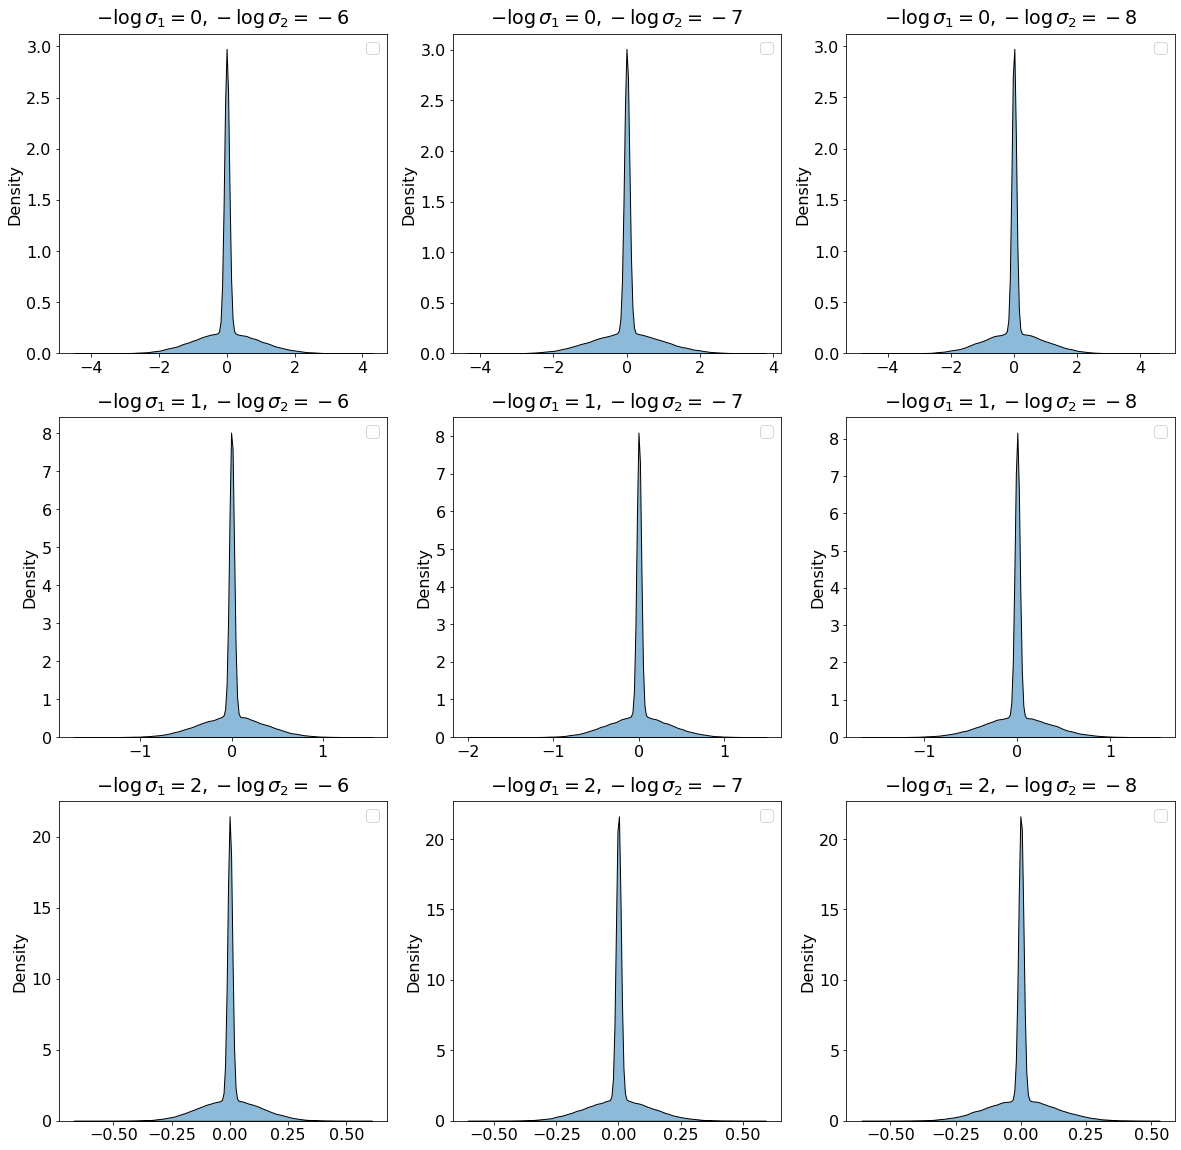

In [17]:
fig, ax = plt.subplots(3, 3, figsize=(20, 20))
for idx, sigma_1 in enumerate([0,1,2]):
    for idy, sigma_2 in enumerate([6,7,8]):
        prior_params_mog = PriorParameters(
            w_sigma=np.exp(-sigma_1),
            b_sigma=np.exp(-sigma_1),
            w_sigma_2=np.exp(-sigma_2),
            b_sigma_2=np.exp(-sigma_2),
            w_mixture_weight=0.5,
            b_mixture_weight=0.5,
        )

        w_mix = distributions.Categorical(torch.tensor((prior_params_mog.w_mixture_weight, 1-prior_params_mog.w_mixture_weight), device=DEVICE))
        b_mix = distributions.Categorical(torch.tensor((prior_params_mog.b_mixture_weight, 1-prior_params_mog.b_mixture_weight), device=DEVICE))

        # Specify the individual components - whilst these appear to be multivariate Gaussians they will be seperated
        w_norm_comps = distributions.Normal(torch.zeros(2, device=DEVICE), torch.tensor((prior_params_mog.w_sigma, prior_params_mog.w_sigma_2), device=DEVICE, dtype=torch.float32))
        b_norm_comps = distributions.Normal(torch.zeros(2, device=DEVICE), torch.tensor((prior_params_mog.b_sigma, prior_params_mog.b_sigma_2), device=DEVICE, dtype=torch.float32))

        # Easier version to play around with
        # w_norm_comps = distributions.Normal(torch.tensor([-1.,1.], device=DEVICE), torch.tensor((prior_params_mog.w_sigma, prior_params_mog.w_sigma_2), device=DEVICE, dtype=torch.float32))
        # b_norm_comps = distributions.Normal(torch.tensor([0.,0.], device=DEVICE), torch.tensor((prior_params_mog.b_sigma, prior_params_mog.b_sigma_2), device=DEVICE, dtype=torch.float32))

        # Create the GMMs
        w_prior_mog = distributions.MixtureSameFamily(w_mix, w_norm_comps)
        b_prior_mog = distributions.MixtureSameFamily(b_mix, b_norm_comps)

        w_prior_mog_samples = w_prior_mog.sample(sample_shape=(100000,))
        sns.kdeplot(w_prior_mog_samples, fill=True, ax=ax[idx, idy], color=colors[0], alpha=0.5, multiple="stack")

        # ax[idx, idy].set_xlim(-4,4)
        # ax[idx, idy].set_ylim(20,23)
        ax[idx, idy].legend()
        ax[idx, idy].set_title(rf'$-\log \sigma_1={sigma_1}, -\log \sigma_2=-{sigma_2}$', pad=10)

In [16]:
torch.diff(w_prior_mog.cdf(torch.tensor([-0.3, 0.3], device=DEVICE)))

tensor([0.9867])

In [17]:
torch.diff(w_prior_mog.cdf(torch.tensor([-0.4, 0.4], device=DEVICE)))

tensor([0.9984])

In [19]:
torch.diff(w_prior_mog.cdf(torch.tensor([-0.5, 0.5], device=DEVICE)))

tensor([0.9999])

In [20]:
w_prior_mog.cdf(torch.tensor([-4], device=DEVICE)), w_prior_mog.cdf(torch.tensor([2], device=DEVICE))

(tensor([0.]), tensor([1.]))

## Laplacian

In [21]:
# w_prior_l = distributions.Laplace(0, prior_params.w_sigma)
# b_prior_l = distributions.Laplace(0, prior_params.b_sigma)

w_prior_l = distributions.Laplace(0, 0.1)
b_prior_l = distributions.Laplace(0, 0.1)

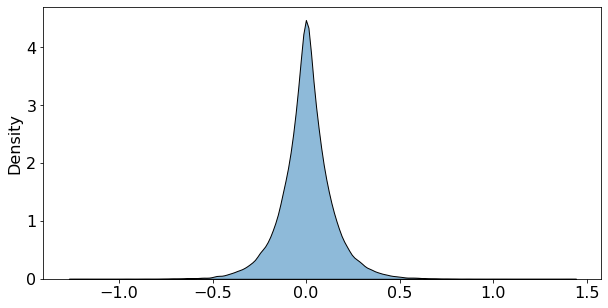

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
w_prior_l_samples =w_prior_l.sample(sample_shape=(100000,))
sns.kdeplot(w_prior_l_samples, fill=True, ax=ax, color=colors[0], alpha=0.5, multiple="stack")
# ax.hist(w_prior_l_samples.cpu().numpy(), bins=100)
pass

## Combined Diagram

In [23]:
w_prior_g = distributions.Normal(0, 1)
b_prior_g = distributions.Normal(0, 1)

w_mix = distributions.Categorical(torch.tensor((0.5, 0.5), device=DEVICE))
b_mix = distributions.Categorical(torch.tensor((0.5, 0.5), device=DEVICE))

# Specify the individual components - whilst these appear to be multivariate Gaussians they will be seperated
w_norm_comps = distributions.Normal(torch.zeros(2, device=DEVICE), torch.tensor((np.exp(-0), np.exp(-7)), device=DEVICE, dtype=torch.float32))
b_norm_comps = distributions.Normal(torch.zeros(2, device=DEVICE), torch.tensor((np.exp(-0), np.exp(-7)), device=DEVICE, dtype=torch.float32))

# Easier version to play around with
# w_norm_comps = distributions.Normal(torch.tensor([-1.,1.], device=DEVICE), torch.tensor((prior_params_mog.w_sigma, prior_params_mog.w_sigma_2), device=DEVICE, dtype=torch.float32))
# b_norm_comps = distributions.Normal(torch.tensor([0.,0.], device=DEVICE), torch.tensor((prior_params_mog.b_sigma, prior_params_mog.b_sigma_2), device=DEVICE, dtype=torch.float32))

# Create the GMMs
w_prior_mog = distributions.MixtureSameFamily(w_mix, w_norm_comps)
b_prior_mog = distributions.MixtureSameFamily(b_mix, b_norm_comps)

w_prior_l = distributions.Laplace(0, 0.15)
b_prior_l = distributions.Laplace(0, 0.15)

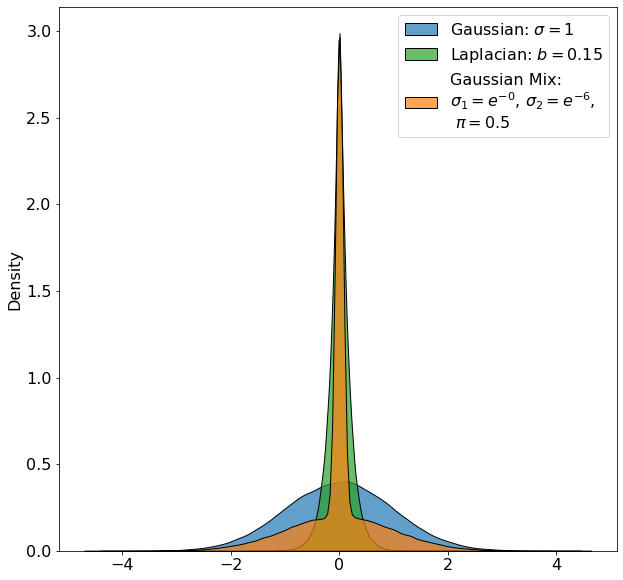

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

w_prior_g_samples = w_prior_g.sample(sample_shape=(100000,))
sns.kdeplot(w_prior_g_samples, fill=True, ax=ax, color=colors[0], alpha=0.7, multiple="stack", label='Gaussian: $\sigma=1$')

w_prior_l_samples =w_prior_l.sample(sample_shape=(100000,))
sns.kdeplot(w_prior_l_samples, fill=True, ax=ax, color=colors[2], alpha=0.7, multiple="stack", label='Laplacian: $b=0.15$')
# ax.hist(w_prior_l_samples.cpu().numpy(), bins=100)

w_prior_mog_samples = w_prior_mog.sample(sample_shape=(100000,))
sns.kdeplot(w_prior_mog_samples, fill=True, ax=ax, color=colors[1], alpha=0.7, multiple="stack", label='Gaussian Mix:\n$\sigma_1=e^{-0}$, $\sigma_2=e^{-6}$,\n $\pi=0.5$')

ax.legend()

plt.savefig(os.path.join("../plots/theory/prior_dist_comp.png"), pad_inches=0.2, bbox_inches='tight')